In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score
import seaborn as sns
import torch
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

In [58]:
from eeg_data_load import load_eeg_data
class_labels = [
    "Normal",
    "Complex_Partial_Seizures",
    "Electrographic_Seizures",
    "Video_detected_Seizures_with_no_visual_change_over_EEG",
]

train_path = "/kaggle/input/eeg-data-final/EEG_Data/train_data"
val_path = "/kaggle/input/eeg-data-final/EEG_Data/validation_data"

In [59]:
X_train, y_train = load_eeg_data(train_path, class_labels)
X_val, y_val = load_eeg_data(val_path, class_labels)

In [163]:
X_train.shape

(5608, 19, 500)

In [115]:
X_train_model = np.load("/kaggle/input/features/X_train.npy")

In [116]:
X_train_model.shape

(5608, 950)

In [96]:
from  model_utility_script import EEGClassifier

model = EEGClassifier(input_size = X_train_model.shape[1])
state_dict = torch.load('/kaggle/input/eeg-classification/pytorch/default/1/EEG Classification.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [17]:
def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32)
    model.eval()  # Ensure model is in evaluation mode
    with torch.no_grad():
        outputs = model(inputs)  # Get logits
        probs = torch.softmax(outputs, dim=1).cpu().numpy()  # Convert to probabilities
    return probs 

In [142]:
X_train.shape, y_train.shape

((5608, 19, 500), (5608,))

In [196]:
CHANNEL_NAMES = [f'C{i+1}' for i in range(19)]

def get_attention_per_channel(attention_weights, num_channels=19):
    """
    Get the attention weights averaged per channel.
    """
    batch_size, hidden_dim = attention_weights.shape
    features_per_channel = hidden_dim // num_channels
    
    # If hidden_dim is not perfectly divisible by num_channels, pad it
    if hidden_dim % num_channels != 0:
        padding_needed = num_channels - (hidden_dim % num_channels)
        attention_weights = F.pad(attention_weights, (0, padding_needed))
        hidden_dim = attention_weights.shape[1]
        features_per_channel = hidden_dim // num_channels
    
    reshaped_attention = attention_weights.view(batch_size, num_channels, features_per_channel)
    channel_attention = reshaped_attention.mean(dim=2)
    return channel_attention


In [197]:
def find_top_channels_per_class(channel_attention, class_logits, num_classes=4):
    """
    Find the top 3 channels contributing to attention weights for each class.
    """
    top_channels = {}
    class_predictions = torch.argmax(class_logits, dim=1)

    for class_idx in range(num_classes):
        class_mask = class_predictions == class_idx
        class_attention = channel_attention[class_mask]

        if class_attention.size(0) > 0:
            avg_attention = class_attention.mean(dim=0)
            top_values, top_indices = torch.topk(avg_attention, k=3)
            # Convert to regular Python lists
            top_channels[class_idx] = (
                top_indices.cpu().numpy().tolist(),
                top_values.cpu().numpy().tolist()
            )
        else:
            top_channels[class_idx] = ([], [])

    return top_channels

In [199]:
# Main execution code
model.eval()
attention_weights = {}

def capture_attention_weights(name):
    def hook(module, input, output):
        attention_weights[name] = output
    return hook

# Register hooks for attention layers
model.attention1.register_forward_hook(capture_attention_weights("attention1"))
model.attention2.register_forward_hook(capture_attention_weights("attention2"))

# Perform forward pass
with torch.no_grad():
    inputs = torch.tensor(X_train_model, dtype=torch.float32)
    logits = model(inputs)
    raw_attention1_weights = attention_weights["attention1"]
    
    # Map attention weights to channels
    channel_attention_weights = get_attention_per_channel(raw_attention1_weights)
    
    # Find top 3 channels per class
    top_channels_per_class = find_top_channels_per_class(channel_attention_weights, logits)
    
    # Print results
    print("\nTop 3 Channels per Class:")
    for class_idx in range(len(class_labels)):
        print(f"\n{class_labels[class_idx]}:")
        indices, weights = top_channels_per_class[class_idx]
        
        for rank, (idx, weight) in enumerate(zip(indices, weights), 1):
            channel_name = CHANNEL_NAMES[int(idx)]  # Convert index to int
            print(f"Rank {rank}: {channel_name} (Weight: {weight:.4f})")



Top 3 Channels per Class:

Normal:
Rank 1: C3 (Weight: 0.1727)
Rank 2: C11 (Weight: 0.1706)
Rank 3: C13 (Weight: 0.1646)

Complex Partial Seizures:
Rank 1: C1 (Weight: 0.1581)
Rank 2: C3 (Weight: 0.1336)
Rank 3: C5 (Weight: 0.1318)

Electrographic Seizures:
Rank 1: C9 (Weight: 0.1829)
Rank 2: C3 (Weight: 0.1674)
Rank 3: C4 (Weight: 0.1545)

Video detected Seizures:
Rank 1: C18 (Weight: 0.6428)
Rank 2: C1 (Weight: 0.4668)
Rank 3: C12 (Weight: 0.4164)


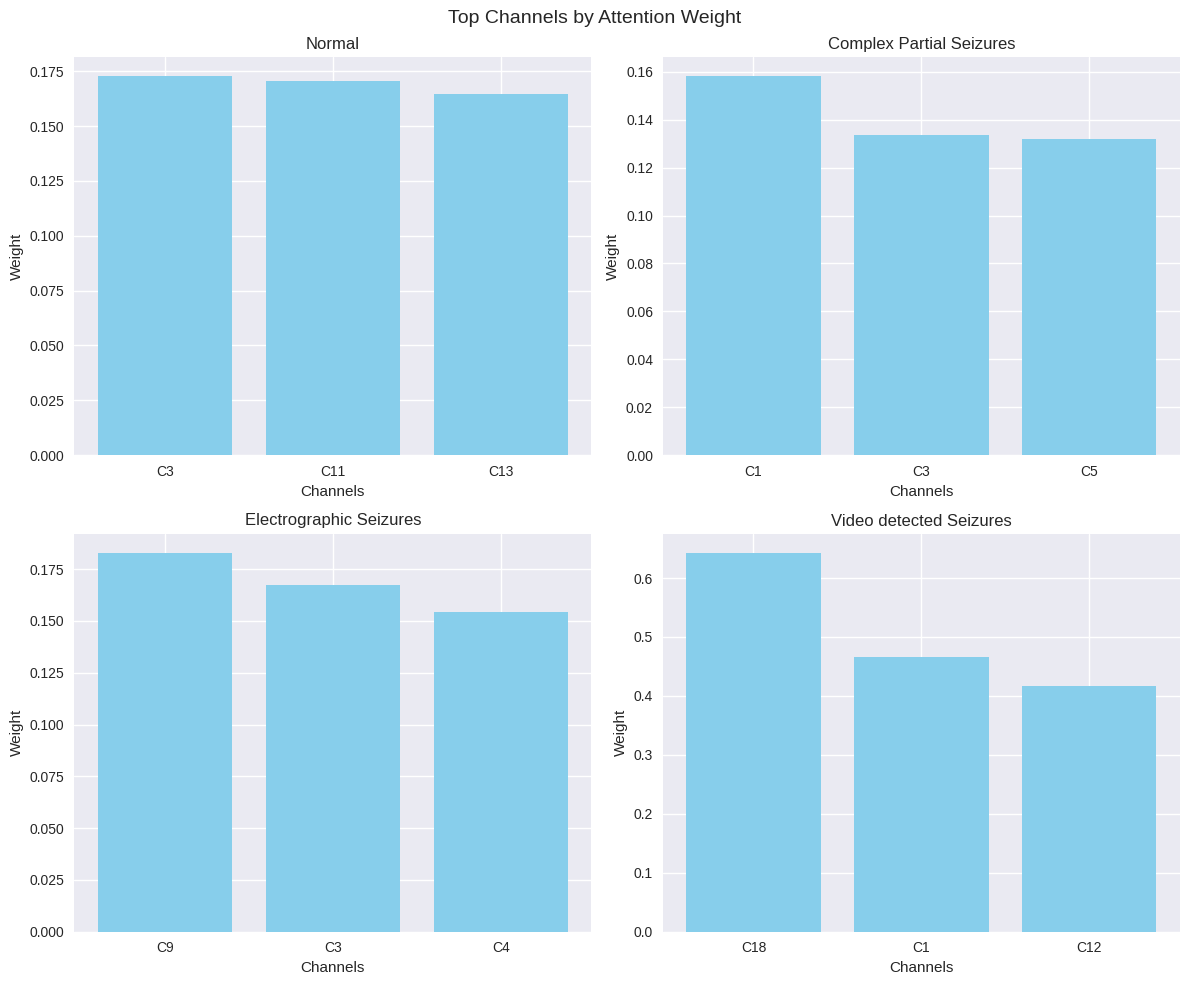

In [201]:
def plot_top_channels(top_channels_per_class, class_labels):
    """
    Create simple bar plots for each class showing top channels.
    """
    # Create a 2x2 subplot
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Top Channels by Attention Weight', fontsize=14)
    
    # Plot for each class
    for class_idx in range(len(class_labels)):
        row = class_idx // 2
        col = class_idx % 2
        ax = axes[row, col]
        
        # Get data for this class
        indices, weights = top_channels_per_class[class_idx]
        channel_names = [CHANNEL_NAMES[int(idx)] for idx in indices]
        
        # Create bar plot with a single color
        ax.bar(channel_names, weights, color='skyblue')
        
        # Customize the plot
        ax.set_title(class_labels[class_idx], fontsize=12)
        ax.set_xlabel('Channels')
        ax.set_ylabel('Weight')
        
        # Rotate x-axis labels
        ax.tick_params(axis='x', rotation=0)
        
    plt.tight_layout()
    plt.show()

# Main execution code
model.eval()
attention_weights = {}

def capture_attention_weights(name):
    def hook(module, input, output):
        attention_weights[name] = output
    return hook

# Register hooks
model.attention1.register_forward_hook(capture_attention_weights("attention1"))
model.attention2.register_forward_hook(capture_attention_weights("attention2"))

# Perform forward pass
with torch.no_grad():
    inputs = torch.tensor(X_train_model, dtype=torch.float32)
    logits = model(inputs)
    raw_attention1_weights = attention_weights["attention1"]
    channel_attention_weights = get_attention_per_channel(raw_attention1_weights)
    top_channels_per_class = find_top_channels_per_class(channel_attention_weights, logits)
    
    # Create the visualization
    plot_top_channels(top_channels_per_class, class_labels)

Orignal Model Parameters

In [202]:
from torch.utils.data import DataLoader, TensorDataset

# Load data
X_val_data = np.load('/kaggle/input/features/X_val.npy')
y_val_data = np.load('/kaggle/input/features/y_val.npy')

# Convert to tensors
X_val_tensor = torch.tensor(X_val_data, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_data, dtype=torch.long)

# Create dataset and dataloader
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32)

# Evaluate the model
results = evaluate_model(model, val_loader, 4)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       696
           1       0.99      0.97      0.98       549
           2       0.99      0.99      0.99       137
           3       1.00      1.00      1.00        21

    accuracy                           0.98      1403
   macro avg       0.99      0.99      0.99      1403
weighted avg       0.98      0.98      0.98      1403

Balanced Accuracy: 0.9875602713580787
AUC-ROC Score: 0.998348272718526


Model Parameters with Masking 

In [214]:
def mask_all_top_channels(X_data, top_channels_per_class, features_per_channel=50):
    """
    Mask (zero out) the top 3 channels for all classes at once.
    """
    masked_data = X_data.clone()
    
    # Collect all unique channels to mask
    channels_to_mask = set()
    for class_idx in top_channels_per_class.keys():
        indices, _ = top_channels_per_class[class_idx]
        channels_to_mask.update([int(idx) for idx in indices])
    
    # Mask each channel
    for channel_idx in channels_to_mask:
        start_idx = channel_idx * features_per_channel
        end_idx = start_idx + features_per_channel
        masked_data[:, start_idx:end_idx] = 0
    
    return masked_data


In [215]:
def evaluate_with_all_channels_masked(model, X_data, y_data, top_channels_per_class):
    """
    Evaluate model performance with all top channels masked.
    """
    model.eval()
    
    # Convert data to tensors if they aren't already
    X_tensor = torch.tensor(X_data, dtype=torch.float32)
    y_tensor = torch.tensor(y_data, dtype=torch.long)
    
    # Mask all top channels
    masked_data = mask_all_top_channels(X_tensor, top_channels_per_class)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(masked_data)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        # Convert to numpy for sklearn metrics
        y_true = y_tensor.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        y_proba = probabilities.cpu().numpy()
        
        # Calculate metrics
        class_report = classification_report(y_true, y_pred)
        balanced_acc = balanced_accuracy_score(y_true, y_pred)
        auc_roc = roc_auc_score(y_true, y_proba, multi_class='ovr')
        
        return class_report, balanced_acc, auc_roc

In [218]:
X_val_data.shape

(1403, 950)

In [219]:
model.eval()
attention_weights = {}

def capture_attention_weights(name):
    def hook(module, input, output):
        attention_weights[name] = output
    return hook

# Register hooks
model.attention1.register_forward_hook(capture_attention_weights("attention1"))
model.attention2.register_forward_hook(capture_attention_weights("attention2"))

# Get top channels first
with torch.no_grad():
    inputs = torch.tensor(X_train_model, dtype=torch.float32)
    logits = model(inputs)
    raw_attention1_weights = attention_weights["attention1"]
    channel_attention_weights = get_attention_per_channel(raw_attention1_weights)
    top_channels_per_class = find_top_channels_per_class(channel_attention_weights, logits)

# Print all channels that will be masked
print("Channels being masked:")
for class_idx, class_name in enumerate(class_labels):
    indices, _ = top_channels_per_class[class_idx]
    print(f"{class_name}: {[CHANNEL_NAMES[int(idx)] for idx in indices]}")

print("\nResults after masking all top channels:")
print("-" * 50)

# Evaluate with all channels masked
class_report, balanced_acc, auc_roc = evaluate_with_all_channels_masked(
    model, 
    X_val_data,  # Use your validation/test data here
    y_val_data,        # Use corresponding labels
    top_channels_per_class
)

print("\nClassification Report:")
print(class_report)
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"AUC-ROC Score: {auc_roc:.4f}")

Channels being masked:
Normal: ['C3', 'C11', 'C13']
Complex Partial Seizures: ['C1', 'C3', 'C5']
Electrographic Seizures: ['C9', 'C3', 'C4']
Video detected Seizures: ['C18', 'C1', 'C12']

Results after masking all top channels:
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.67      0.80       696
           1       0.71      0.98      0.82       549
           2       0.85      0.94      0.90       137
           3       1.00      0.71      0.83        21

    accuracy                           0.82      1403
   macro avg       0.88      0.83      0.84      1403
weighted avg       0.86      0.82      0.82      1403

Balanced Accuracy: 0.8266
AUC-ROC Score: 0.9813
